In [39]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

In [2]:
import os
os.system ("bash -c 'ls docs > doclist.txt'")
doclist = np.loadtxt('doclist.txt', dtype=str)

In [3]:
hash32 = lambda value: hash(value) & 0xffffffff

In [4]:
def shingles(docname, hashfunction=hash32):
    with open('docs/' + docname, 'r') as filename:
        string = ""
        for line in filename:
            string += ' ' + line
    string = string.replace("short article made longer help wikipedia adding", '').strip().split()
    if len(string) == 0:
        return -1
    elif len(string) == 1:
        return [hashfunction(string[0]),]
    elif len(string) == 2:
        return [hashfunction(string[0] + string[1]),]
    else:
        triples = set()
        for i in xrange(2, len(string)):
            triples.add(string[i-2] + string[i-1] + string[i])
        hashes = []
        for el in triples:
            hashes.append(hashfunction(el))
        return sorted(hashes)[:min(100, len(hashes))]

In [5]:
def levenshteinDistance(s, len_s, t, len_t):
    if len_s == 0:
        return len_t
    if len_t == 0:
        return len_s
 
    if s[len_s - 1] == t[len_t - 1]:
        cost = 0
    else:
        cost = 1
 
    return min(levenshteinDistance(s, len_s - 1, t, len_t    ) + 1,\
               levenshteinDistance(s, len_s    , t, len_t - 1) + 1,\
               levenshteinDistance(s, len_s - 1, t, len_t - 1) + cost)

In [6]:
def levenshteinDistanceOpt(s, t):
    m = len(s)
    n = len(t)
    
    d = np.zeros((m + 1, n + 1))
    for i in xrange(1, m + 1):
        d[i, 0] = i
    for j in xrange(1, n + 1):
        d[0, j] = j
 
    for j in xrange(1, n + 1):
        for i in xrange(1, m + 1):
            if s[i - 1] == t[j - 1]:
                d[i, j] = d[i-1, j-1] 
            else:
                d[i, j] = min(d[i-1, j] + 1, d[i, j-1] + 1, d[i-1, j-1] + 1)
 
    return d[m, n]

In [7]:
def trueDistance(leftdocname, rightdocname):
    with open('docs/' + leftdocname, 'r') as leftfile:
        leftwords = ""
        for line in leftfile:
            leftwords += ' ' + line
    leftwords = leftwords.replace("short article made longer help wikipedia adding", '').strip().split()
    with open('docs/' + rightdocname, 'r') as rightfile:
        rightwords = ""
        for line in rightfile:
            rightwords += ' ' + line
    rightwords = rightwords.replace("short article made longer help wikipedia adding", '').strip().split()
    
    maxlen = max(len(leftwords), len(rightwords))
    
    distance = levenshteinDistanceOpt(leftwords, rightwords)
    
    return float(distance) / maxlen

In [8]:
thetime = time()
nonemptydocs = dict()
for i in xrange(doclist.shape[0]):
    hashes = shingles(doclist[i])
    if hashes != -1:
        nonemptydocs[doclist[i]] = hashes
print time() - thetime

4.00903391838


In [11]:
nonemptydocnames = nonemptydocs.keys()

10596 - слишком много (будет считаться примерно 5 дней в текущем состоянии), оставим  1000

In [16]:
import random
random.shuffle(nonemptydocnames)
nonemptydocnames = nonemptydocnames[:1000]

In [18]:
trueDist = np.zeros((len(nonemptydocnames),len(nonemptydocnames))) + 1

In [19]:
thetime = time()
i = 0
for leftel in nonemptydocnames:
    j = 0
    for rightel in nonemptydocnames:
        if j > i and len(set(nonemptydocs[rightel]).intersection(set(nonemptydocs[leftel]))) > 0:
            dist = trueDistance(leftel, rightel)
            trueDist[i,j], trueDist[j,i] = dist, dist
        elif i == j:
            trueDist[i,j] = 0
        j += 1
    i += 1
    if i % 100 == 0:
        print i, time() - thetime
print time() - thetime

100 755.459010124
200 1762.50293994
300 2737.296592
400 3409.36638999
500 3979.82613897
600 4422.91764212
700 4670.05799294
800 4818.46723604
900 4947.5784061
1000 4986.5058279
4986.50601101


In [22]:
docpairscount = len(nonemptydocnames) * (len(nonemptydocnames) - 1) /2

In [33]:
estimDistDiff = np.zeros((101 - 10, docpairscount))

In [34]:
thetime = time()
for n in xrange(10, 101):
    l = 0
    for i in xrange(len(nonemptydocnames)):
        for j in xrange(i + 1, len(nonemptydocnames)):
            leftset = set(nonemptydocs[nonemptydocnames[i]][:min(n, len(nonemptydocs[nonemptydocnames[i]]))])
            rightset = set(nonemptydocs[nonemptydocnames[j]][:min(n, len(nonemptydocs[nonemptydocnames[j]]))])
            if len(leftset.intersection(rightset)) > 0:
                dist = 1. - float(len(leftset.intersection(rightset))) / len(leftset.union(rightset))
                estimDistDist[n - 10, l] = trueDist[i, j] - dist
            else:
                estimDistDiff[n - 10, l] = trueDist[i, j] - 1 
            l += 1
print time() - thetime

825.853595972


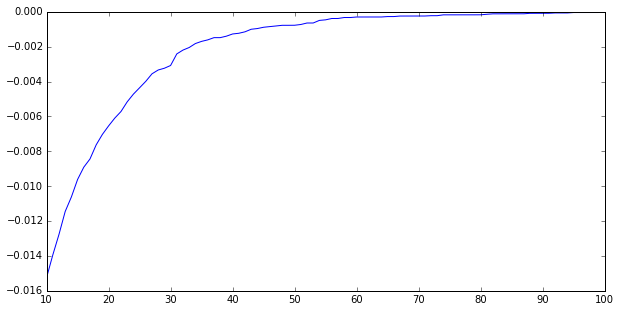

In [41]:
plt.figure(figsize=(10,5))
plt.plot(np.array(range(10,101)), np.mean(estimDistDiff, axis=1))

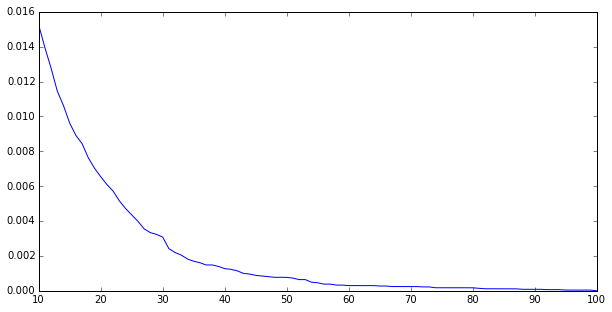

In [43]:
plt.figure(figsize=(10,5))
plt.plot(np.array(range(10,101)), np.mean(np.abs(estimDistDiff), axis=1))

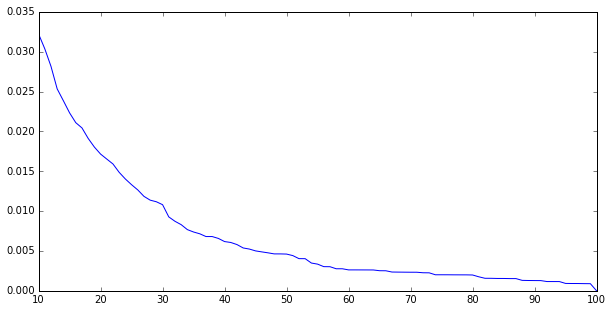

In [42]:
plt.figure(figsize=(10,5))
plt.plot(np.array(range(10,101)), np.std(estimDistDiff, axis=1))

Итого: качество монотонно возрастает, но после N=60 незначительно.